# Genetic Algorithm for Traveling Salesman Problem

![GA](ga.png)

Few definitions rephrased in the context of the TSP:   
- **Gene**: a City ([x, y] coordinate)  
- **Individual/Chromosome**: a Single Route satisfying the conditions above   
- **Population**: a collection of possible routes  
- **Parents**: Two routes that are combined to create a new route   
- **Mating pool**: a collection of parents that are used to create our new population (for next generation of routes)      
- **Fitness**: a function that tells us how good each route is   
- **Mutation**: a way to introduce variation in our population by randomly swapping two cities in a route   
- **Elitism**: a way to carry the best individuals into the next generation   

**Steps:**
1. Create the population (Collection of possible routes) 
2. Determine Fitness   
3. Select the mating pool (For the next routes)  
4. Breed, Mutate, and Repeat   

## CODE:

In [1]:
import numpy as np 
import pandas as pd
import random 
import operator
import matplotlib.pyplot as plt

City class will allow us to create and handle our cities. These are simply our (x, y) coordinates.

In [2]:
class City:
    def __init__(self, x, y):
        """
        Class City used to create Nodes of the Graph
        """
        self.x = x
        self.y = y
    
    def distance(self, city):
        """
        Eucledian distance is considered for demo
        """
        xd = abs(self.x - city.x)
        yd = abs(self.y - city.y)
        distance = np.sqrt((xd ** 2) + (yd ** 2))
        return distance
    
    def __repr__(self):
        """
        this method is for output
        """
        return "(" + str(self.x) + "," + str(self.y) + ")"
    

The fitness is the inverse of the route distance. The larger the fitness score, the lesser the route distance. 

In [3]:
class Fitness:
    def __init__(self, route):
        """
        Fitness measure is used for selection of the 
        fittest route i.e. Shortest path
        """
        self.route = route
        self.distance = 0
        self.fitness = 0.0
        
    def routeDistance(self):
        """
        Method calculates the distance of the path
        given during the run
        """
        if self.distance == 0:
            pathDistance = 0
            for i in range(0, len(self.route)):
                fromCity = self.route[i]
                toCity = None
                if (i + 1) < len(self.route):
                    toCity = self.route[i + 1]
                else:
                    toCity = self.route[0]
                pathDistance += fromCity.distance(toCity)
            self.distance = pathDistance
        return self.distance
    
    def routeFitness(self):
        """
        Depending on the distance, 
        a fitness score is assigned to each route
        """
        if(self.fitness == 0):
            self.fitness = 1/float(self.routeDistance())
        return self.fitness

**Create the population**   
To make our initial population, we need a way to create a function that produces routes. To create an individual, we randomly select the order in which we visit each city.

In [4]:
#Create the population
def createRoute(cityList):
    """
    It randomly generates a route.
    Used during initialization i.e. Step 1
    """
    route = random.sample(cityList, len(cityList))
    return route

The above method produces one individual but we want a full population, so let's do that in our next function. This is as simple as looping through *createRoute* function until we have as many routes as we want for our population.

**PS: We only have to use these functions to create the initial population. Subsequent generations will be produced through breeding and mutation.**

In [5]:
def initialPopulation(popSize, cityList):
    """
    Generates population of initial routes
    Used during initialization
    """
    population = []

    for i in range(0, popSize):
        population.append(createRoute(cityList))
    return population

**Determine Fitness**   
To simulate our "survival of the fittest", we can make use of *Fitness* to rank each individual (route) in the population. Our output will be order list with the route ids and each associated fitness score.

In [6]:
#Determine Fitness
def rankRoutes(population):
    """
    Calculates fitness of the generated routes
    """
    fitnessResults = {}
    for i in range(0,len(population)):
        fitnessResults[i] = Fitness(population[i]).routeFitness()
    return sorted(fitnessResults.items(), key = operator.itemgetter(1), reverse = True)

**Select the Mating pool**   
This Step is used to create the next generation. We will be using the concept of **Elitism**. With elitism, the best performing individuals from the population will automatically carry over to the next generation, ensuring that the most successful individuals persist.

Step 1: We'll use the Output from the *rankRoutes* to determine which routes to select in our *Selection* function. Ultimately, the *selection* function returns a list of route ids, which we can use to create the mating pool in the *matingPool* function.

In [7]:
#Select Mating pool
def selection(popRanked, eliteSize):
    """
    Based on the fitness score,
    a route is selected. More the Fitness, less the path distance
    """
    selectionResults = []
    df = pd.DataFrame(np.array(popRanked), columns=["Index","Fitness"])
    df['cum_sum'] = df.Fitness.cumsum()
    df['cum_perc'] = 100*df.cum_sum/df.Fitness.sum()
    
    for i in range(0, eliteSize):
        selectionResults.append(popRanked[i][0])
    for i in range(0, len(popRanked) - eliteSize):
        pick = 100*random.random()
        for i in range(0, len(popRanked)):
            if pick <= df.iat[i,3]:
                selectionResults.append(popRanked[i][0])
                break
    return selectionResults

Now, that we have the IDs of the routes that will make up our mating pool from the selection function, we can create the mating pool. We're simply extracting the selected individuals from our population.

In [8]:
def matingPool(population, selectionResults):
    """
    Extracting the best routes out of the population
    """
    matingpool = []
    for i in range(0, len(selectionResults)):
        index = selectionResults[i]
        matingpool.append(population[index])
    return matingpool

**Breed**   
With our mating pool created, we can create the next generation in a process called crossover. TSP is unique in that we need to include all locations exactly once time. To abide by this rule, we can use a special breeding function called ordered crossover. In it, we randomly select a subset of the first parent string and then fill the remainder of the route with the genes from the second parent in the order in which they appear, without duplicating any genes in the selected subset from the first parent. 

In [9]:
def breed(parent1, parent2):
    """
    CrossOver Algorithm applied to create
    near route by Breeding the fittest existing paths
    """
    child = []
    childP1 = []
    childP2 = []
    
    geneA = int(random.random() * len(parent1))
    geneB = int(random.random() * len(parent1))
    
    startGene = min(geneA, geneB)
    endGene = max(geneA, geneB)

    for i in range(startGene, endGene):
        childP1.append(parent1[i])
        
    childP2 = [item for item in parent2 if item not in childP1]

    child = childP1 + childP2
    return child

Next, we'll generalize this to create our offspring population. We use elitism to retain the best routes from the current population. Then we use the *breed* function to fill out the rest of the next generation.

In [10]:
def breedPopulation(matingpool, eliteSize):
    """
    Merge the previous two function, to give out new offSprings
    """
    children = []
    length = len(matingpool) - eliteSize
    pool = random.sample(matingpool, len(matingpool))

    for i in range(0,eliteSize):
        children.append(matingpool[i])
    
    for i in range(0, length):
        child = breed(pool[i], pool[len(matingpool)-i-1])
        children.append(child)
    return children

**Mutate**   
Mutation serves an important function in GA, as it helps to avoid local convergence by introducing novel routes that will allow us to explore other parts of the solution space. Similar to crossover, the TSP has a special consideration when it comes to mutation.   
   
Since we need to abide by our rules, we can't drop cities. Instead, we'll use swap mutation. This means that, with specified low probability, two cities will swap places in our route. We'll do this for our individual in our function.

In [11]:
def mutate(individual, mutationRate):
    """
    Mutation done.
    It randomly flips the numbers in order to change the path
    The probability of flip is extremely low in most cases
    """
    for swapped in range(len(individual)):
        if(random.random() < mutationRate):
            swapWith = int(random.random() * len(individual))
            
            city1 = individual[swapped]
            city2 = individual[swapWith]
            
            individual[swapped] = city2
            individual[swapWith] = city1
    return individual

Next, we extend the mutate function to run through the next population.

In [12]:
def mutatePopulation(population, mutationRate):
    """
    Make the Mutate function run through the population
    """
    mutatedPop = []
    
    for ind in range(0, len(population)):
        mutatedInd = mutate(population[ind], mutationRate)
        mutatedPop.append(mutatedInd)
    return mutatedPop

To put it all together, first we rank the routes in the current generation using **rankRoutes**. We then determine our potential parents by running the selection function, which allows us to create the mating pool using the **matingPool** function. Finally, we then create our new generation using the **breedPopulation** function and then applying mutation using the **mutatePopulation** funciton.

In [13]:
def nextGeneration(currentGen, eliteSize, mutationRate):
    """
    Creating next generation of OffSprings
    """
    popRanked = rankRoutes(currentGen)
    selectionResults = selection(popRanked, eliteSize)
    matingpool = matingPool(currentGen, selectionResults)
    children = breedPopulation(matingpool, eliteSize)
    nextGeneration = mutatePopulation(children, mutationRate)
    return nextGeneration

In [14]:
def geneticAlgorithm(population, popSize, eliteSize, mutationRate, generations):
    """
    Putting together all the function so far to run as one
    """
    pop = initialPopulation(popSize, population)
    print("Initial distance: " + str(1 / rankRoutes(pop)[0][1]))
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
    
    print("Final distance: " + str(1 / rankRoutes(pop)[0][1]))
    bestRouteIndex = rankRoutes(pop)[0][0]
    bestRoute = pop[bestRouteIndex]
    return bestRoute


With everything in place, we now import the list of cities with x and y coordinates.

In [15]:
df = pd.read_csv('../data.csv', header=None)
cityList = []
for i in range(len(df[0])):
    xy = df[0][i].split(' ')
    cityList.append(City(x=float(xy[1]), y=float(xy[2])))
cityList = cityList[:500]

In [16]:
def geneticAlgorithmPlot(population, popSize, eliteSize, mutationRate, generations):
    pop = initialPopulation(popSize, population)
    progress = []
    progress.append(1 / rankRoutes(pop)[0][1])
    
    for i in range(0, generations):
        pop = nextGeneration(pop, eliteSize, mutationRate)
        progress.append(1 / rankRoutes(pop)[0][1])
    
    plt.plot(progress)
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.show()

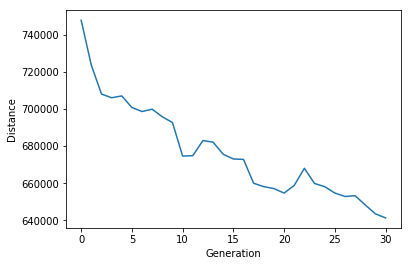

In [22]:
geneticAlgorithmPlot(population=cityList, popSize=100, \
                     eliteSize=30, \
                     mutationRate=0.01, generations=30)

In [26]:
bri = geneticAlgorithm(population=cityList, popSize=500, \
                     eliteSize=30, \
                     mutationRate=0.01, generations=30)


Initial distance: 713671.2221987181
Final distance: 657333.4256455986


Sources:   
1. https://towardsdatascience.com/evolution-of-a-salesman-a-complete-genetic-algorithm-tutorial-for-python-6fe5d2b3ca35